# Homework 2 (Part II)

Aprendizagem 2023/2024 - LEIC @ IST 

Group #24
- Daniel Nunes (Nº 103095)
- Gonçalo Alves (Nº 103540)

## Data importing and preparation

In [1]:
import pandas as pd, numpy as np
from scipy.io.arff import loadarff

data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


In [2]:
X = df.drop('class', axis=1);
Y = df['class'];

Using sklearn, apply a 10-fold stratified cross-validation with shuffling (`random_state=0`) for the 
assessment of predictive models along this section. 

## Exercise 1

Compare the performance of kNN with k=5 and naïve Bayes with Gaussian assumption 
(consider all remaining parameters for each classifier as sklearn’s default): 

**a.** Plot two boxplots with the fold accuracies for each classifier.

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

knn_accuracy = []
nb_accuracy = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

X_array = np.array(X)
y_array = np.array(Y)

for train_index, test_index in skf.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    Y_train, Y_test = y_array[train_index], y_array[test_index]

    # Treine e ajuste o classificador kNN
    knn = KNeighborsClassifier(n_neighbors=5)  # k=5
    knn.fit(X_train, Y_train)
    knn_pred = knn.predict(X_test)
    knn_acc = accuracy_score(Y_test, knn_pred)
    knn_accuracy.append(knn_acc)

    # Treine e ajuste o classificador Naïve Bayes Gaussiano
    nb = GaussianNB()
    nb.fit(X_train, Y_train)
    nb_pred = nb.predict(X_test)
    nb_acc = accuracy_score(Y_test, nb_pred)
    nb_accuracy.append(nb_acc)

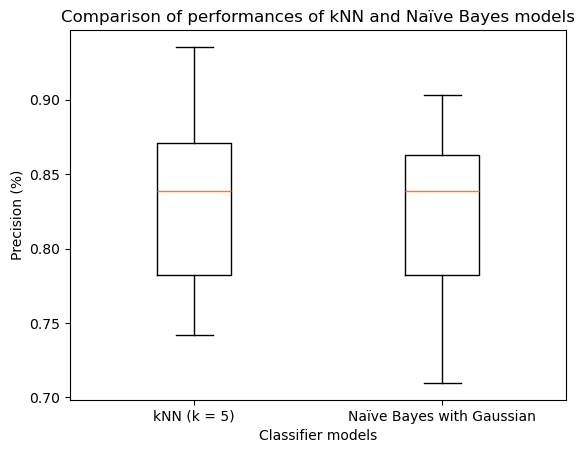

In [4]:
import matplotlib.pyplot as plt

plt.boxplot([knn_accuracy, nb_accuracy], labels=['kNN (k = 5)', 'Naïve Bayes with Gaussian'], widths=(0.3, 0.3))
plt.xlabel('Classifier models')
plt.ylabel('Precision (%)')
plt.title('Comparison of performances of kNN and Naïve Bayes models')
plt.show()

**b.** Using scipy, test the hypothesis “𝑘NN is statistically superior to naïve Bayes regarding 
accuracy”, asserting whether is true. 

In [5]:
from scipy import stats

p_value = stats.ttest_rel(knn_accuracy, nb_accuracy).pvalue
print(f"P-Value: {p_value}")

P-Value: 0.38085618124128184


**Our answer**

Since the P-Value generated by the t_test function is approximately equal to 0.38, then we cannot conclude if kNN is more accurate than the Naïve Bayes approach, since only a P-Value lower than 0.05 would indicate a discrepancy on the accuracies returned by both classifiers.

## Exercise 2

Consider two kNN predictors with k=1 and k=5 (uniform weights, Euclidean distance, 
all remaining parameters as default). Plot the differences between the two cumulative confusion 
matrices of the predictors. Comment.

In [6]:
from sklearn.metrics import confusion_matrix

kNN_1_confusion_matrices = []
kNN_5_confusion_matrices = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

X_array = np.array(X)
y_array = np.array(Y)

for train_index, test_index in skf.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    Y_train, Y_test = y_array[train_index], y_array[test_index]

    # k = 1
    kNN_1 = KNeighborsClassifier(n_neighbors=1)
    knn1_predictor = kNN_1.fit(X_train, Y_train)
    kNN_1_predictions = kNN_1.predict(X_test)
    kNN_1_confusion_matrix = confusion_matrix(Y_test, kNN_1_predictions)
    kNN_1_confusion_matrices.append(kNN_1_confusion_matrix)

    # k = 5
    kNN_5 = KNeighborsClassifier(n_neighbors=5)
    knn5_predictor = kNN_5.fit(X_train, Y_train)
    kNN_5_predictions = kNN_5.predict(X_test)
    kNN_5_confusion_matrix = confusion_matrix(Y_test, kNN_5_predictions)
    kNN_5_confusion_matrices.append(kNN_5_confusion_matrix)

kNN_1_cumulative_confusion = sum(kNN_1_confusion_matrices)
kNN_5_cumulative_confusion = sum(kNN_5_confusion_matrices)

kNN_confusion_difference = kNN_1_cumulative_confusion - kNN_5_cumulative_confusion

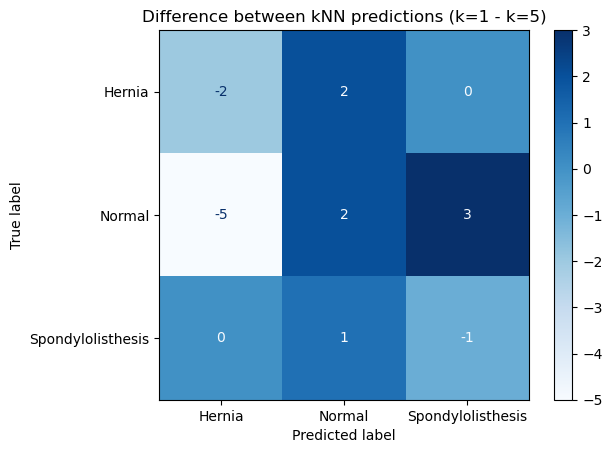

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

matrix_display = ConfusionMatrixDisplay(confusion_matrix=kNN_confusion_difference, display_labels=knn1_predictor.classes_)
matrix_display.plot(cmap=plt.cm.Blues)
plt.title("Difference between kNN predictions (k=1 - k=5)")
plt.show()

**Our answer**

Given the result above, we can observe that the model with k=5 performs better in correctly classifying new items as Hernia and Spondylolisthesis, while the kNN model with k=1 performs better in classifying it as Normal. Because of this, the first model is probably less successful than the second at correctly identifying the various instances of each class.

Furthermore, the second model seems to have less false positives and, more importantly, less false negatives, which can be a more critical factor for diagnosing patients according to the properties used in the "column_diagnosis" dataset.

Therefore, by analysing the results of this confusion matrix, we can conclude that a bigger value of k in a kNN predictor can lead to a better impact in the model's performance.

## Exercise 3

Considering the unique properties of `column_diagnosis`, identify three possible difficulties 
of naïve Bayes when learning from the given dataset.

**Our answer**

We can observe three possible problems of using a naïve Bayes classifier for learning the `column_diagnosis` dataset:

1. Almost all inputs of this dataset are continuous variables, which means that, when using a Bayesian approach for creating a model from this data, it automatically assumes that each continuous variable follows a certain distribution (tipically a Gaussian distribution). However, if some of the variables of this dataset follow other distributions, using a naïve Bayes model might create some errors.

2. Naïve Bayes assumes that features are conditionally independent given the class label. This is done in order to try to achieve better optimization results while not sacrificing accuracy. However, we cannot fully confirm that the variables are completely independent from one another. If this is not the case, then the accuracy of the Bayesian model can decrease substantially.

3. After analysing this dataset, we concluded that there are 60 data points for the class "Hernia", 100 for the class "Normal" and 150 for a diagnosis of "Spondylolisthesis". Therefore, the classes in this dataset are imbalanced. This can introduce bias on the naïve model, meaning that for each new set of properties, the model can have a bigger chance of classifying it as one class, as it was trained with more data for that specific class.